In [ ]:
import re
import glob
import pandas as pd


def extract_time(filename):

    match = re.search(r'm(\d+\.\d+)', filename)
    if match:

        return float(match.group(1))

    return 0


archivos_ovf = sorted(glob.glob('*.ovf'))

sorted_files = sorted(archivos_ovf, key=extract_time)


for archivo in sorted_files:
    print(f'Archivo: {archivo}, Valor extraído: {extract_time(archivo)}')

Archivo: m000000.ovf, Valor extraído: 0
Archivo: m000001.ovf, Valor extraído: 0
Archivo: m000002.ovf, Valor extraído: 0
Archivo: m000003.ovf, Valor extraído: 0
Archivo: m000004.ovf, Valor extraído: 0
Archivo: m000005.ovf, Valor extraído: 0
Archivo: m000006.ovf, Valor extraído: 0
Archivo: m000007.ovf, Valor extraído: 0
Archivo: m000008.ovf, Valor extraído: 0
Archivo: m000009.ovf, Valor extraído: 0
Archivo: m000010.ovf, Valor extraído: 0
Archivo: m000011.ovf, Valor extraído: 0
Archivo: m000012.ovf, Valor extraído: 0
Archivo: m000013.ovf, Valor extraído: 0
Archivo: m000014.ovf, Valor extraído: 0
Archivo: m000015.ovf, Valor extraído: 0
Archivo: m000016.ovf, Valor extraído: 0
Archivo: m000017.ovf, Valor extraído: 0
Archivo: m000018.ovf, Valor extraído: 0
Archivo: m000019.ovf, Valor extraído: 0
Archivo: m000020.ovf, Valor extraído: 0
Archivo: m000021.ovf, Valor extraído: 0


# Calcular Posição e velocidade

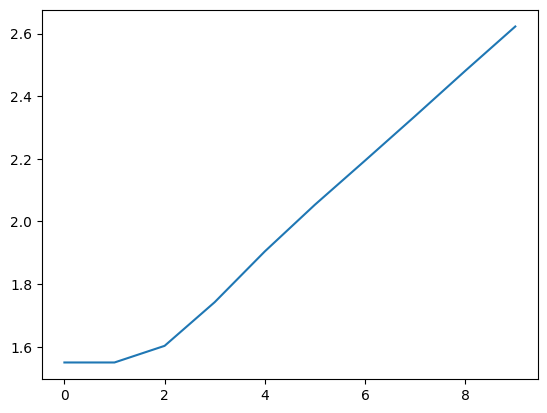

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


coord = np.zeros((540*540*40, 3))

#Tamanho do sistema
beta = 1
EMaior = 500
EMenor = beta*EMaior
p = 0
for k in range(40):
    z = 1 + 2 * k
    for j in range(540):
        y = 1 + 2 * j
        for i in range(540):
            x = 1 + 2 * i
            coord[p, 0] = x - 540
            coord[p, 1] = y - 540
            coord[p, 2] = z - 40
            p += 1

archivos_ovf = sorted_files

SKPOS = np.zeros((len(archivos_ovf), 7))

for kk, archivo in enumerate(sorted_files):
    mag = np.loadtxt(archivo, skiprows=28)
    posicion = coord

    x = posicion[:, 0]
    y = posicion[:, 1]
    z = posicion[:, 2]
    mx = mag[:, 0]
    my = mag[:, 1]
    mz = mag[:, 2]

    # Filtrar os dados com a condição -450 < x < 450
    mask = (x > -450) & (x < 450)
    x = x[mask]
    y = y[mask]
    z = z[mask]
    mx = mx[mask]
    my = my[mask]
    mz = mz[mask]

    u = np.arctan2(beta*y, x)
    rho = np.sqrt(x**2 + y**2) - EMaior*np.sqrt(np.cos(u)**2 + beta*np.sin(u)**2)
    v = np.arctan2(z, rho)
    v[z < 0] = -v[z > 0]

    tx = -np.sin(v) * np.cos(u)
    ty = -np.sin(v) * np.sin(u)
    tz = np.cos(v)

    #
    m = mx*tx + my*ty  + mz*tz



    # Filtrar os dados onde m**2 >= 0.90
    pos = np.where(m <= -0.98)
    xp = x[pos]
    yp = y[pos]
    zp = z[pos]
    mxx = mx[pos]
    myy = my[pos]
    mzz = mz[pos]
    txp = tx[pos]
    typ = ty[pos]
    tzp = tz[pos]
    up = u[pos]
    vp = v[pos]
    rhop = rho[pos]
    mpos = m[pos]

    # Criar DataFrame para os dados filtrados
    df_filtered = pd.DataFrame({
        'x': xp,
        'y': yp,
        'z': zp,
        'mx': mxx,
        'my': myy,
        'mz': mzz,
        'tx': txp,
        'ty': typ,
        'tz': tzp,
        'u': up,
        'v': vp,
        'rho': rhop,
        'm': mpos
    })

    # Guardar o arquivo TXT
    output_filename = f"filtered_data_{kk}.txt"
    df_filtered.to_csv(output_filename, sep='\t', index=False, float_format='%.6f')

    # Calcular e salvar a posição do skyrmion
    SKPOS[kk, 0] = kk
    SKPOS[kk, 1] = np.mean(xp)
    SKPOS[kk, 2] = np.mean(yp)
    SKPOS[kk, 3] = np.mean(zp)
    u_mean = np.arctan2(SKPOS[kk, 2], SKPOS[kk, 1])
    rho_mean = np.sqrt(SKPOS[kk, 1]**2 + SKPOS[kk, 2]**2) - EMaior*np.sqrt(np.cos(u_mean)**2 + beta*np.sin(u_mean)**2)
    v_mean = np.arctan2(SKPOS[kk, 3], rho_mean)
    if SKPOS[kk, 3] < 0:
        v_mean = -v_mean
    SKPOS[kk, 4] = v_mean
    SKPOS[kk, 5] = u_mean

     #Calcular a velocidade angular (diferença entre u_mean e o valor anterior de u_mean)
    if kk > 0:
        delta_u = SKPOS[kk , 5] - SKPOS[kk - 1, 5]  # Diferença entre u medios consecutivos
        delta_t = 5e-11  # Intervalo de tempo (supondo que é constante)
        velocity_angular = delta_u / delta_t
    else:
        velocity_angular = 0  # Para o primeiro valor, a velocidade angular é zero

    SKPOS[kk, 6] = velocity_angular  # Armazenar a velocidade angular na coluna 6

    #print(f"Arquivo {kk} processado e salvo: {output_filename}")



# Salvar o arquivo resumo
plt.plot( SKPOS[:,0],SKPOS[:,5] )
df_skpos = pd.DataFrame(SKPOS, columns=['Tempo', 'PosX', 'PosY', 'PosZ', 'v', 'u', 'velocidade'])
df_skpos.to_excel('SKPOS.xlsx', index=False)
df_skpos.to_csv('SKPOS.txt', sep='\t', index=False, float_format='%.6f')


# Cálculo da Velocidade (Comprimento do Arco)

# Ansatz

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


coord = np.zeros((540*540*40, 3))

# Tamanho do sistema
beta = 1
EMaior = 450
EMenor = beta * EMaior
p = 0
for k in range(40):
    z = 1 + 2 * k
    for j in range(540):
        y = 1 + 2 * j
        for i in range(540):
            x = 1 + 2 * i
            coord[p, 0] = x - 540
            coord[p, 1] = y - 540
            coord[p, 2] = z - 40
            p += 1

archivos_ovf = sorted_files

SKPOS = np.zeros((len(archivos_ovf), 7))

for kk, arquivo in enumerate(sorted_files):
    mag = np.loadtxt(arquivo, skiprows=28)
    posicion = coord

    x = posicion[:, 0]
    y = posicion[:, 1]
    z = posicion[:, 2]
    mx = mag[:, 0]
    my = mag[:, 1]
    mz = mag[:, 2]

    # Filtrar os dados com a condição -20 < x < 20
    mask = (z==29)&(x > -400) & (x < 400) & ((mx != 0) | (my != 0) | (mz != 0))
    x = x[mask]
    y = y[mask]
    z = z[mask]
    mx = mx[mask]
    my = my[mask]
    mz = mz[mask]

    u = np.arctan2(beta * y, x)
    rho = np.sqrt(x**2 + y**2) - EMaior * np.sqrt(np.cos(u)**2 + beta * np.sin(u)**2)
    v = np.arctan2(z, rho)
    #v[z < 0] = -v[z > 0]

    #Vetor tangente 1
    vx = np.sin(v) * np.cos(u)
    vy = np.sin(v) * np.sin(u)
    vz = -np.cos(v)

    #Vetor tangente 2
    ux = -np.sin(u)
    uy = np.cos(u)
    uz = 0

    #Vetor normal

    nx = np.cos(v)*np.cos(u)
    ny = np.cos(v)*np.sin(u)
    nz = np.sin(v)


    Theta = np.arccos(mx*ux + my*uy)

    # Calcula phi
    numerador_phi = mx*nx + my*ny + mz*nz
    denominador_phi = mx*vx + my*vy + mz*vz

    Phi = np.arctan2(numerador_phi, denominador_phi)  # Usa arctan2 para considerar os quadrantes corretamente


    # Obtemos a componente rho da magnetização
    Mn = np.sin(Theta)*np.sin(Phi)  #Componente normal da magnetização

    Mu = np.cos(Theta) # Componente tangencial

    Mv = np.sin(Theta)*np.cos(Phi) #Componete na direção v



    # Filtrar os dados onde m**2 <= 1.0
    pos = np.where(mx >= -1)
    up = u[pos]
    vp = v[pos]
    mxx = Mu[pos]
    myy = Mv[pos]
    mzz = Mn[pos]
    Phip = Phi[pos]
    Thetap = Theta[pos]

    # Criar DataFrame para os dados filtrados
    df_filtered = pd.DataFrame({
        'u': up,
        'v': vp,
        'mu': mxx,
        'mv': myy,
        'mn': mzz,
        'Phi': Phip,
        'Theta': Thetap
    })

    # Ordenar os dados por u em ordem crescente
    df_filtered = df_filtered.sort_values(by='u')

    # Guardar o arquivo TXT
    output_filename = f"filtered_data_{kk}.txt"
    df_filtered.to_csv(output_filename, sep='\t', index=False, float_format='%.6f')




<ipython-input-7-595bf7a2f1d4>:70: RuntimeWarning: invalid value encountered in arccos
  Theta = np.arccos(mx*ux + my*uy)


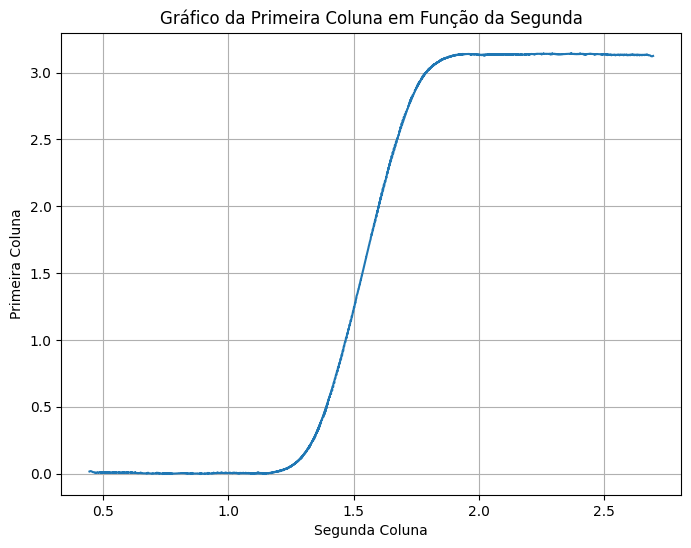

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Nome do arquivo TXT
arquivo_txt = "/content/filtered_data_0.txt"  # Substitua pelo nome do seu arquivo

# Ler a tabela ignorando possíveis cabeçalhos
dados = pd.read_csv(arquivo_txt, sep='\t', header=None)  # Ajuste 'sep' conforme necessário

# Verificar se há pelo menos 2 colunas
if dados.shape[1] < 2:
    raise ValueError("O arquivo deve conter pelo menos duas colunas para o gráfico.")

# Extrair as colunas desejadas
x = dados.iloc[:, 0]  # Segunda coluna
y = dados.iloc[:, 6]  # Primeira coluna

# Criar o gráfico
plt.figure(figsize=(8, 6))
plt.plot(x, y, linestyle = '-')
plt.xlabel("Segunda Coluna")
plt.ylabel("Primeira Coluna")
plt.title("Gráfico da Primeira Coluna em Função da Segunda")
plt.grid()
plt.show()
